In [19]:
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bids.modeling import BIDSStatsModelsGraph
from bids.layout import BIDSLayout, BIDSLayoutIndexer
from bids.tests import get_test_data_path
from os.path import join
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from prep_report_py.utils import generate_tablecontents, get_bidstats_events
import json
import warnings
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)


In [3]:
generate_tablecontents("transformations.ipynb")            

# Table of Contents

- [ Fitlins Transformations: Subject-Level Modeling](#-Fitlins-Transformations-Subject-Level-Modeling)
  - [ Focus on Subject-Level Models](#-Focus-on-Subject-Level-Models)
  - [ PyBIDS Transformations Summary](#-PyBIDS-Transformations-Summary)
- [ Spec Files and Model Outputs](#-Spec-Files-and-Model-Outputs)
  - [ ds003425: Applying Factors, Convolve and Filter](#-ds003425-Applying-Factors-Convolve-and-Filter)
    - [ Apply *Factor* to trial_type](#-Apply-Factor-to-trial_type)
    - [ Convolve trial_type Factors](#-Convolve-trial_type-Factors)
    - [ Create New Regressor using *Filter*](#-Create-New-Regressor-using-Filter)
  - [ ds004711: Applying DropNA, Rename, Factors, Convolve](#-ds004711-Applying-DropNA-Rename-Factors-Convolve)
    - [ Rename, Factor & Rename](#-Rename-Factor--Rename)
    - [ Add DropNA](#-Add-DropNA)
- [ Common Fitlins Log Errors](#-Common-Fitlins-Log-Errors)
  - [ Inconsistent Runs files per subject](#-Inconsistent-Runs-files-per-subject)
  - [ Missing subjects for session](#-Missing-subjects-for-session)
  - [ Error in onset / duration / type column](#-Error-in-onset--duration--type-column)
- [ Pilot Errors](#-Pilot-Errors)

# Fitlins Transformations: Subject-Level Modeling

This notebook summarizes key Fitlins transformations for subject-level models, drawing from the following resources:

- [PyBIDS StatsModels Tutorial](https://bids-standard.github.io/pybids/examples/statsmodels_tutorial.html)
- [Mumford's Transformations Slides](https://docs.google.com/presentation/d/1Bsfx9K4jz-YveUA4JpmqK-s1LnFNqFaGemEDbgFBoOc/edit#slide=id.g1269976e58a_0_306)
- [Tal’s PyBIDS Transformations Document](https://docs.google.com/document/d/1uxN6vPWbC7ciAx2XWtT5Y-lBrdckZKpPdNUNpwRxHoU/edit?tab=t.0)

The multi-state modeling is describe on the [BIDS Stats Model page](https://bids-standard.github.io/stats-models/walkthrough-1.html). The examples there are particularly helpful to understand what the `groupby` feature does and how the levels are performed within each `node`.

## Focus on Subject-Level Models

Modifying multiple files can be tedious, making programmatic transformations more efficient. While group- and participant-level modifications are often simpler (e.g., relabeling groups by sex or condition), this notebook focuses on subject-level transformations which benefit the most from automation. 

In this example, we are solely focused on using the general linear model (GLM) for analyzing time-series data at the subject level, which is given by:

$$
Y = X\beta + \varepsilon
$$

where:
- **Y** is the observed time-series data (e.g., BOLD response in fMRI),
- **X** is the design matrix containing predictors (e.g., task regressors, motion parameters),
- **β** represents the regression coefficients (parameter estimates),
- **ε** is the residual error term, assumed to be normally distributed: \( \varepsilon \sim \mathcal{N}(0, \sigma^2 I) \).

## PyBIDS Transformations Summary

[Tal’s PyBIDS Transformations Document](https://docs.google.com/document/d/1uxN6vPWbC7ciAx2XWtT5Y-lBrdckZKpPdNUNpwRxHoU/edit?tab=t.0) covers several transformation options. Within the context of BIDS Stats-Models, using "pybids-transforms-v1", here's a summary of the transformation names and their functions:

**Core Transformations: In order of presentation**
* **Factor:** Converts categorical variables into dummy-coded (binary) indicator variables.
* **Convolve:** Convolves time-series data with a hemodynamic response function (HRF) model.
* **Filter:** Subsets rows based on a boolean expression.
* **And/Or:** Performs logical AND or OR operations on multiple columns, producing a single boolean output.
* **Assign:** Copies or reassigns values from one column to another, potentially changing attributes like onset or duration.
* **Demean:** Centers a column by subtracting its mean.
* **DropNA:** Removes rows containing missing values.
* **Group:** Creates a named group of variables for easier referencing.
* **Lag:** Shifts a column's values by a specified number of time points.
* **Log10:** Computes the base-10 logarithm of a column.
* **Not:** Performs logical negation on a column.
* **Orthogonalize:** Removes the linear relationship between columns.
* **Product:** Calculates the row-wise product of multiple columns.
* **Rename:** Changes the name of a column.
* **Replace:** Substitutes values within a column.
* **Resample:** Changes the sampling rate of a column.
* **Scale:** Standardizes a column by centering and scaling.
* **Select:** Retains only specified columns, removing others.
* **Split:** Splits a column into multiple columns based on the values of other columns.
* **Sum:** Calculates the row-wise sum of multiple columns.
* **Threshold:** Applies a cutoff to a column's values, optionally binarizing them.

***Not Reviewed***

* **Copy:** Creates a duplicate of a column under a new name.
* **Delete:** Removes specified columns from the dataset.
* **ToDense:** Converts sparse (onset/duration) data to dense (continuous) time-series data.

As described in the [BIDS Extension Proposal 2](https://docs.google.com/document/d/1bq5eNDHTb6Nkx3WUiOBgKvLNnaa5OMcGtD0AZ9yms2M/edit?tab=t.0), the nodes are performed in the order of:
* run → subject → dataset  
* run → session → subject → dataset  
* run → subject  
* subject → dataset


# Spec Files and Model Outputs

## ds003425: Applying Factors, Convolve and Filter

For this analyses, I defer to the papers description in their [methods section](https://www.nature.com/articles/s41598-022-05019-y#Sec32:~:text=fMRI%20preprocessing%20and%20whole%2Dbrain%20univariate%20analysis):
*The data were analyzed within the General Linear Model using a multi-level mixed-effects design. At the single-participant level each run was modelled separately. We used a double-gamma hemodynamic response function (HRF) with which each of the conditions of interest (i.e., onset to offset of either viewing or imaging a given Gabor) was convolved. We included a model for the temporal derivative of each condition of interest. We also included several nuisance regressors including six motion correction parameters, and motion censoring regressors for any volume with > 0.9 mm framewise displacement104 using the fsl_motion_outliers function. As noted previously we also modelled CS+ reinforced (i.e., shock) trials and the first and last CS− trials as two separate regressors that were not used in higher-level analyses (they were modelled similar to the conditions of interest). A second-level analysis was performed in order to combine contrast estimates from the first level separately for each experimental phase (e.g., the conditioning phase) for each participant. This was completed using a fixed effects model, by forcing the random effects variance to zero in FLAME (FMRIB's Local Analysis of Mixed Effects)105,106,107. Group-level analyses were carried out using FLAME (FMRIB's Local Analysis of Mixed Effects) stage 1 and stage 2 with automatic outlier detection105,106,107. The resulting Z (Gaussianised T/F) statistic images were corrected for multiple comparisons using FSL’s cluster thresholding algorithm that applies Gaussian Random Field Theory to estimate the probability of observing clusters of a given size. We applied a threshold of Z > 2.3 and a (corrected) cluster size probability of p = 0.05108. All whole-brain unthresholded group-level maps can be viewed at neurovault.org using the link: https://identifiers.org/neurovault.collection:5138.*

While their [OpenNeuro](https://openneuro.org/datasets/ds003425/versions/1.0.2) README contains some description, it is hard to get a complete mapping of what the variables mean to what the paper refers to. The below tries to provide some clarity. 

Remapping based on labels and paper descriptions.
    
**Experiment 1**
[Learning]

    1 = csp shock (CS+ viewed with shock)
    2 = csp noshock (CS+ viewed without shock)
    3 = cspi (CS+ imagined)
    4 = csm (CS- viewed)
    5 = csmi (CS- imagined)

[Pre-training] *i think*

    2 = csp noshock (CS+ viewed without shock)
    3 = cspi (CS+ imagined)
    4 = csm (CS- viewed)
    5 = csmi (CS- imagined)

[Training]

    ShockOn: 1= on; 2= off (This refers to if the shock was delivered during that trial)

**Experiment 2**

[Regulate]

    1. csp shock (CS+ viewed with shock)
    2 = csp noshock (CS+ viewed without shock)
    3 = cspi (CS+ imagined while viewing CS-)
    4 = csm (CS- viewed)
    5 = csmi (CS- imagined while viewing CS+)



Simple model: Performing a groupby and basic trial_type transformation to "factor".
The model we are running will also use [ignore](https://fitlins.readthedocs.io/en/latest/usage.html#:~:text=to%20include%20files-,%2D%2Dignore,-regex%20pattern%20or) to filter out files that will result in a break with this dataset as we are not planning to use them (e.g., physio files)

In [7]:
study_id = 'ds003425'
bids_inp = f"/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/openneuro_cloned/openneuro/{study_id}"
ignore_indexer = BIDSLayoutIndexer(ignore=["sub-.*_physio\.(json|tsv\.gz)"])

### Apply *Factor* to trial_type

To create a "Factor" tranformation, we would add the following to our set of transformations our run level node that is grouping by Run, sbject and session.

```python
{
"Name": "Factor",
"Input": [
    "trial_type"
]
}
```

In [8]:

pect_fact = {
  "Name": "ds003425",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "01"
  ],
    "task": [
      "learning"
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject",
        "session"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          }
          
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*", # not available because fmriprep confound.tsv not present
          "rot*",
          "cosine*"
        ],
        "Type": "glm"
      }
    }
  ]
}

Use the function defined above, 

In [9]:
events_df, root_mod = get_bidstats_events(bids_inp, pect_fact, scan_length=250, ignored=["sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
events_df 

,duration,onset,run,session,subject,trial_type,datatype,suffix,task
0,6.5,3.544157,1,01,01,4,func,bold,learning
1,6.5,23.571931,1,01,01,1,func,bold,learning
2,6.5,43.599812,1,01,01,2,func,bold,learning
3,6.5,63.627571,1,01,01,3,func,bold,learning
4,6.5,83.655411,1,01,01,4,func,bold,learning
5,6.5,103.683288,1,01,01,3,func,bold,learning
6,6.5,123.711044,1,01,01,5,func,bold,learning
7,6.5,143.738938,1,01,01,5,func,bold,learning
8,6.5,163.766710,1,01,01,2,func,bold,learning
9,6.5,183.794586,1,01,01,4,func,bold,learning


Below is the events file for the returned subject. This will not be changed in transformations, so it will not be repeated later.

In [ ]:
print(events_df.dtypes)

In [ ]:
outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)


The resulting model, "X" below covers the regressors that will be included when fit to the data. Notice, values only represent the occurence of each event at the *onset* of the trial type (1-5). This would be inconsistent with the papers model, "*We used a double-gamma hemodynamic response function (HRF) with which each of the conditions of interest (i.e., onset to offset of either viewing or imaging a given Gabor) was convolved.*"


Because the trial_type regressors include trial types 1-5, the fitlins model would make these regressor to achieve:

1) Modeling regressors of interest (viewing / imaging CS+ / CS-)
2) *"As noted previously we also modelled CS+ reinforced (i.e., shock) trials*" 

So a separate regressor for (1) will no longer be necessary.

In [ ]:
outputs[0].X

The below is the design matrix, which shows that the regressors are not consistent with something that would match a full length timeseries. In other words, `length(BOLD_TIMES) =! length(design_matrix)`

In [ ]:
plot_design_matrix(outputs[0].X)

### Convolve trial_type Factors

After the factors are created (first transformation), in the next step we would like to convolve the regressors with our HRF. To do this, we can add:
```python
{
"Name": "Convolve",
"Model": "spm",
"Input": [
    "trial_type.*"
]
}
```

In [ ]:
pect_convolve = {
  "Name": "ds003425",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "01"
  ],
    "task": [
      "learning"
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject",
        "session"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*", # not available because fmriprep confound.tsv not present
          "rot*",
          "cosine*"
        ],
        "Type": "glm"
      }
    }
  ]
}

Now that we specified the convolution type in our spec file, we can run our model (as we did above) and plot the design matrix. The plotted version is easier to see as now the convolved will be equivalent to our scan length in time (e.g. volumes * time repetition).

Now, the regressors appear to have been convolved. 

In [ ]:
events_df, root_mod = get_bidstats_events(bids_inp, pect_convolve, scan_length=250, ignored=["sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
events_df

outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)
plot_design_matrix(outputs[0].X)

But, the paper said they convolve their regressors using, "*gamma hemodynamic response function (HRF) with which each of the conditions of interest (i.e., onset to offset of either viewing or imaging a given Gabor) was convolved. We included a model for the temporal derivative of each condition of interest*". However, the above design matrix doesn't include any derivatives. We can revise the convolution to include the derivative for each regressor.

```python
{
    "Name": "Convolve",
    "Model": "spm",
    "Derivative": "True",
    "Input": [
        "trial_type.*"
    ]
}
```

The arguments for the convolution include:
```python
{
    "Name": "Convolve", 
    "Model": "", # string; spm, glover, fir, Default = 'spm'
    "Derivative": "", # boolean; whther to add temporal derivative True/False, Default = False
    "Despersion": "", # boolean; whether to add dispersion, Default = False
    "FIRDelays": []
    "Input": [], # REQUIRED: ListVariables to convolve
    "Output": [] # Renamed convolved to new variables? Default inplace convolution
}
```


In [ ]:

pect_convderv = {
  "Name": "ds003425",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "01"
  ],
    "task": [
      "learning"
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject",
        "session"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Derivative": "True",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*", # not available because fmriprep confound.tsv not present
          "rot*",
          "cosine*"
        ],
        "Type": "glm"
      }
    }
  ]
}

In [ ]:
events_df, root_mod = get_bidstats_events(bids_inp, pect_convderv, scan_length=250, ignored=["sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
events_df


outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)
plot_design_matrix(outputs[0].X)

The design matrix indicates that the 'derivative' term is included for each regressor. While the heatmap of the design matrix isn't as clear that the regressor is correct, we can plot the timeseries plot to get a better visual. Since the derivative term should be orthogonal to the regressor, we can confirm they are not corrolated.

In [ ]:
dfcpy = outputs[0].X.drop(columns=["intercept"]).copy()
df_values = dfcpy.to_numpy()

plt.figure(figsize=(20, 10))
for i, col in enumerate(dfcpy.columns):
    plt.plot(np.arange(df_values.shape[0]), df_values[:, i], label=col)  

plt.xlabel("TR")
plt.ylabel("Amplitude")
plt.title("HRF Across TR by trial_type")
plt.legend()
plt.show()


In [ ]:
correlation_matrix = np.corrcoef(df_values, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=dfcpy.columns, 
            vmax = 1, vmin=-1, yticklabels=dfcpy.columns)
plt.title("Correlation Matrix")
plt.show()

### Create New Regressor using *Filter*

The next challenge: Can BIDSStatsModel Transformation achieve something a bit complex. For example, "*the first and last CS− trials as [a] separate regressor that were [is] used in higher-level analyses (they were modelled similar to the conditions of interest)."*? Simply put, this new regressor that takes the the first and last instance of 4 (CS-viewed) AND 5 (CS-imagined). What this looks like outside of the BIDS Stats Model workflow:

In [ ]:
subset_df = events_df[events_df['trial_type'].isin([4, 5])]
first_last_df = subset_df.iloc[[0, -1]].copy()
first_last_df['trial_type'] = "fst_lst"
events_cpy = pd.concat([events_df, first_last_df], ignore_index=True)
events_cpy['trial_type'] = events_cpy['trial_type'].astype('str')
events_cpy['trial_type'] = 'trial_type.' + events_cpy['trial_type']

convolved_df = make_first_level_design_matrix(
    frame_times = np.arange(125) * 2,
    events= events_cpy[['onset','duration','trial_type']],
    hrf_model = 'spm + derivative',
    drift_model = None)

plot_design_matrix(convolved_df)

So we have a design matrix that has the first and last events from CS- (i.e. trial_type == 3 OR == 5). Unfortunately, there is insufficient flexibility in the tool to take ONLY the first instance of trial_type.3 == 1 AND trial_type.5 == 1 == [0] AND [-1]

BIDSStatsModels can query based on condition type in trials, but that will not achieve what we want based on the instance/occurence of the events, e.g.

```python
          {
            "Name": "Filter",
            "Input": ["trial_type.1"],
            "Query": "trial_type.1 == 1",
            "Output": ["CPSshock"]
          }
```

This is a `limitation` of BIDS Stats Models transformations, so in this instance, events files would need to be preprocessed before fitting them. Whereas the filtering technique has flexibility to groupby other features, it would have to be pretty cumbersome to achieve something that'd normally take 3-lines of code.

```python
          {
            "Name": "Filter",
            "Input": [""], # List of variables
            "Query": "", # boolean filter to use
            "By": "", # optional: column to group by (e.g., if we wanted to filter by another column)
            "Output": [""] # columns to output to, otherwise performed inplace
          }
```

In [ ]:
pect_filter = {
  "Name": "ds003425",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "01"
  ],
    "task": [
      "learning"
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject",
        "session"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Filter",
            "Input": ["trial_type.1"],
            "Query": "trial_type.1 == 1",
            "Output": ["CPSshock"]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*",
              "CPSshock"
            ]
          }
          
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "CPSshock",
          "trans_*",
          "rot*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "VCSPvVCSN",
          "ConditionList": ["trial_type.2", "trial_type.4"],
          "Weights": [1, -1],
          "Test": "t"
        },
        {
          "Name": "ICSPvICSN",
          "ConditionList": ["trial_type.3","trial_type.5"],
          "Weights": [1, -1],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast",
        "session"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    }
  ]
}

In [ ]:
events_df, root_mod = get_bidstats_events(bids_inp, pect_filter, scan_length=250, ignored=["sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
events_df = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)

In [ ]:
outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)
plot_design_matrix(outputs[0].X)

## ds004711: Applying DropNA, Rename, Factors, Convolve

In this set of examples, we will take a look at OpenNeuro Dataset [ds004711](https://openneuro.org/datasets/ds004711/versions/1.0.0). The methods for this paper are available in the corresponding [paper](https://link.springer.com/article/10.3758/s13415-022-01060-6#Sec5). In this case, the events files have (1) onset and (2) duration, but they do not include (3) trial_type information. 

The paper methods for GLM include, "*we included separate onset vectors for linear, exponential and control balloons (i.e., displays), as well as parametric modulation regressors for each of these balloon types, reflecting the demeaned pump number with regard to the entire trial. To explicitly model and thus remove other trial-relevant events from the implicit baseline activation, we also included onset vectors for explosions, as well as the six head motion parameters estimated during the spatial realignment procedure*"

So their model, excluding head motion, will include in GLM:

1. linear, exponential and control balloon regressors
2. parametric modulator across ALL trials (values in events, but if were not, ***should*** be best to create OUTSIDE of fitlins.)
3. parametric modulator for EACH balloon type (values in events, but if were not, ***need*** to generate OUTSIDE of fitlins.)
4. explosion occurence

There is no "trial_type" column, so we will want to create it and include the already created regressors for demeand all / by type trials.


To create trial type, we will use `Rename`.
```python
{
    "Name": "Rename",
    "Input": ["balloon_type"],
    "Output": ["trial_type"]
}
```

Recall, the requirements for the `Rename` function in transformations are:
```python
{
    "Name": "Rename",
    "Input": [], # mandatory list, to rename 
    "Output": [] # rename label, order matches input
}
```

### Rename, Factor & Rename

In [157]:
bartspec = {
  "Name": "ds004711",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "001",
      "002",
      "003",
      "004",
      "005"],
    "task": [
      "bart"
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Rename",
            "Input": ["balloon_type"],
            "Output": ["trial_type"]
          },
          {
            "Name": "Factor",
            "Input": ["trial_type","balloon_outcome"]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*",
              "balloon_outcome.explosion"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "pumps_demean_all",
          "pumps_demean_type",
          "balloon_outcome.explosion"
        ],
        "Type": "glm"
      }
    }
  ]
}

In [158]:
study_id = 'ds004711'
TR = 2.0
volumes = 319
scan_length = volumes * TR
bids_inp = f"/Users/demidenm/Desktop/Academia/Stanford/9_ResearchSci/OpenNeuro/MetaData/openneuro_cloned/openneuro/{study_id}"
events_df, root_mod = get_bidstats_events(bids_inp, bartspec, scan_length=scan_length, ignored=["sub-.*_physio\.(json|tsv\.gz)"],return_events_num=0)
events_df.sort_values(by='onset', ascending=True, inplace=True)
events_df

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.reset_index().replace("n/a", fillna)


,duration,subject,onset,run,balloon_colour,balloon_idx,balloon_maxpumps,balloon_number,balloon_outcome,balloon_payoff_cumulative,...,balloon_type,duration_explosion,onset_explosion,pumps,pumps_demean_all,pumps_demean_type,response,datatype,suffix,task
190,1.702,001,4.054,1,grey,1,15,1,control,0.0,...,control,NaN,NaN,15,-6.307692,-9.444444,pump,func,bold,bart
110,0.664,001,7.471,1,grey,2,15,1,control,0.0,...,control,NaN,NaN,15,-5.307692,-8.444444,pump,func,bold,bart
159,1.014,001,9.204,1,grey,3,15,1,control,0.0,...,control,NaN,NaN,15,-4.307692,-7.444444,pump,func,bold,bart
87,0.527,001,11.654,1,grey,4,15,1,control,0.0,...,control,NaN,NaN,15,-3.307692,-6.444444,pump,func,bold,bart
33,0.330,001,13.892,1,grey,5,15,1,control,0.0,...,control,NaN,NaN,15,-2.307692,-5.444444,pump,func,bold,bart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.968,001,614.093,1,grey,11,15,26,control,0.0,...,control,NaN,NaN,15,3.692308,0.555556,pump,func,bold,bart
119,0.738,001,616.243,1,grey,12,15,26,control,0.0,...,control,NaN,NaN,15,4.692308,1.555556,pump,func,bold,bart
121,0.740,001,618.226,1,grey,13,15,26,control,0.0,...,control,NaN,NaN,15,5.692308,2.555556,pump,func,bold,bart
67,0.423,001,620.510,1,grey,14,15,26,control,0.0,...,control,NaN,NaN,15,6.692308,3.555556,pump,func,bold,bart


In [159]:
outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.reset_index().replace("n/a", fillna)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/modeling/statsmodels.py:714: UserWarning: NaNs detected in columns: Index(['trial_type.control', 'trial_type.exponential', 'trial_type.linear',
       'pumps_demean_all', 'pumps_demean_type', 'balloon_outcome.explosion'],
      dtype='object') were replaced with 0.  Consider  handling missing values using transformations.
  warnings.warn(base_message)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior

There are a lot of 'NA' value alerts. Which we can inspect by looking at the transformed data output. We can review several of the variables that are highlighted to contain 'NaN'. Notice, `pumps_demean_type` and `pumps_demean_all` has 17 NaN values. 

Can we just proceed with our GLM anyways? Let's try...

In [181]:
columns_check = ['trial_type.control', 'trial_type.exponential', 'trial_type.linear',
       'pumps_demean_all', 'pumps_demean_type', 'balloon_outcome.explosion']

for col in columns_check:
    num_nan = outputs[0].trans_hist[2].output.to_df(entities=False)[col].isnull().sum()
    print(f"Column {col} has {num_nan} NA values \n")

Column trial_type.control has 0 NA values 

Column trial_type.exponential has 0 NA values 

Column trial_type.linear has 0 NA values 

Column pumps_demean_all has 17 NA values 

Column pumps_demean_type has 17 NA values 

Column balloon_outcome.explosion has 0 NA values 



/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.reset_index().replace("n/a", fillna)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.reset_index().replace("n/a", fillna)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior 

Plotting the design matrix, it is apparent that the trial_type and explosion regressors are convolved with out HRF, but the demeaned values are empty / zero. Let's consider handling these cases in our sequence of transformations.

<AxesSubplot:label='conditions', ylabel='scan number'>

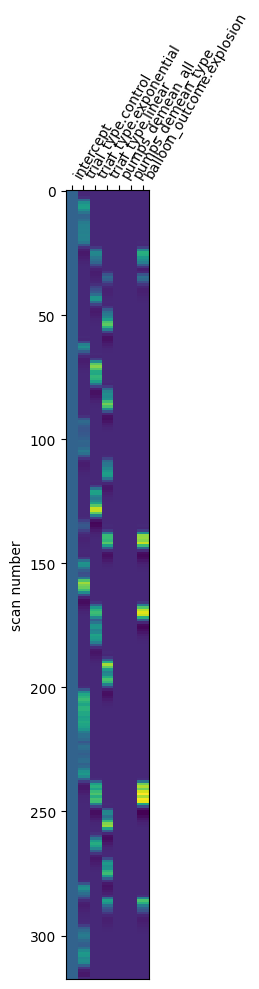

In [178]:
plot_design_matrix(outputs[0].X)

### Add DropNA

To drop missing values, we can add `DropNA` into our sequence of transformations.

We will apply it to both of the demeaned parametric regressors
```python
{
    "Name": "DropNA",
    "Input": ["pumps_demean_all", "pumps_demean_type"]
}
```

Recall, the requirements for the `DropNA` function in transformations are:
```python
{
    "Name": "DropNA",
    "Input": [], # mandatory list, list of variables to rename
    "Output": [] # rename label, order matches input. Default: overwrites column
}
```

In [182]:
dropna = {
  "Name": "ds004711",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "001",
      "002",
      "003",
      "004",
      "005"],
    "task": [
      "bart"
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "DropNA",
            "Input": ["pumps_demean_all", "pumps_demean_type"]
          },
          {
            "Name": "Rename",
            "Input": ["balloon_type"],
            "Output": ["trial_type"]
          },
          {
            "Name": "Factor",
            "Input": ["trial_type","balloon_outcome"]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*",
              "balloon_outcome.explosion"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "pumps_demean_all",
          "pumps_demean_type",
          "balloon_outcome.explosion"
        ],
        "Type": "glm"
      }
    }
  ]
}

In [183]:
events_df, root_mod = get_bidstats_events(bids_inp, dropna, scan_length=scan_length, ignored=["sub-.*_physio\.(json|tsv\.gz)"],return_events_num=0)

outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)
outputs[0].trans_hist[2].output.to_df(entities=False)

/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.reset_index().replace("n/a", fillna)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/modeling/statsmodels.py:714: UserWarning: NaNs detected in columns: Index(['trial_type.control', 'trial_type.exponential', 'trial_type.linear',
       'balloon_outcome.explosion'],
      dtype='object') were replaced with 0.  Consider  handling missing values using transformations.
  warnings.warn(base_message)
/Users/demidenm/miniconda3/envs/brain_env/lib/python3.11/site-packages/bids/modeling/statsmodels.py:714: UserWarning: NaNs detected in columns: Index(['trial_type.control', 'trial_ty

,duration,onset,balloon_colour,balloon_idx,balloon_maxpumps,balloon_number,balloon_outcome,balloon_payoff_cumulative,balloon_payoff_total,duration_explosion,onset_explosion,pumps,pumps_demean_all,pumps_demean_type,response,trial_type
0,0.064,576.843,red,3,5,25,explosion,0.300000,0.0,NaN,NaN,5,-4.307692,-2.444444,pump,linear
1,0.074,504.461,red,3,7,21,cashout,0.300000,0.5,NaN,NaN,5,-4.307692,-2.444444,pump,linear
2,0.107,578.643,red,4,5,25,explosion,0.400000,0.0,NaN,NaN,5,-3.307692,-1.444444,pump,linear
3,0.126,307.590,grey,6,10,14,control,0.000000,0.0,NaN,NaN,10,-1.307692,-4.444444,pump,control
4,0.133,303.573,grey,4,10,14,control,0.000000,0.0,NaN,NaN,10,-3.307692,-6.444444,pump,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2.151,415.558,grey,6,14,18,control,0.000000,0.0,NaN,NaN,14,-1.307692,-4.444444,pump,control
197,2.173,426.041,grey,9,14,18,control,0.000000,0.0,NaN,NaN,14,1.692308,-1.444444,pump,control
198,2.181,317.257,grey,9,10,14,control,0.000000,0.0,NaN,NaN,10,1.692308,-1.444444,pump,control
199,2.481,252.690,blue,7,14,11,cashout,0.595259,0.6,NaN,NaN,7,-0.307692,1.125000,pump,exponential


Now the regressors appear to have been correctly convolved and the demeaned estimates are present. As opposed to before, they were listed but zero.

<AxesSubplot:label='conditions', ylabel='scan number'>

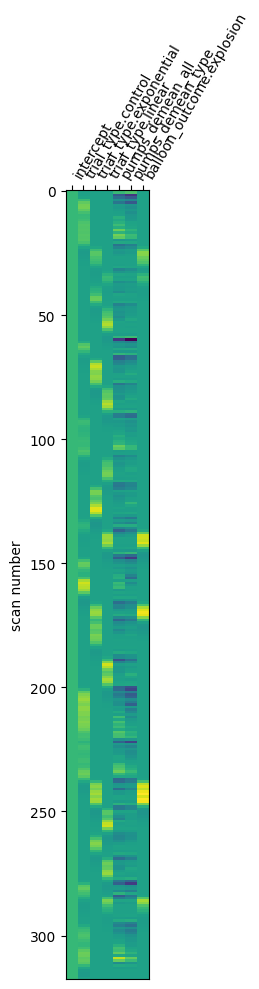

In [184]:
plot_design_matrix(outputs[0].X)

# Common Fitlins Log Errors

## Inconsistent Runs files per subject
If subjects are expected to have 3 events files that for <task-name>, but some have fewer, when Fitlins stacks the events it may result in a mismatch in number of information.

*nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node loader.*
*Traceback:*
*ValueError: Length of values (85) does not match length of index (98))*


## Missing subjects for session 

Sometimes fitlins will assume a file exists that it may parse (e..g cf = confounds), but it is missing because a subject is missing that session / run. For example, Fitlins fails when sub-01 has 5 runs for ses-02 regulate task, sub-04 is missing, and some subjects has runs 07/08 runs for regulate task. This creates an imbalance in grabbing files. 

*Traceback:*

...

    *_data = pd.read_csv(cf.path, sep='\t', na_values='n/a')*
...
*pandas.errors.EmptyDataError: No columns to parse from file*



## Error in onset / duration / type column

If there are errors in these columns, the setup of the amplitudes (transformation convolving with HRF) will fail. An error may include:

*Traceback:*
        
        *TypeError: '<' not supported between instances of 'float' and 'str'*

In this instance, the trial_type column had 'strings' and 'n/a' values. 

# Pilot Errors

### Inconsistent Subjects / Runs / Sessions

In [6]:
def counts_boldconfevents(file_list, datatype_name):
    """Extract metadata from BIDS file list and tag with datatype."""
    data = []
    for file in file_list:
        entities = file.entities
        data.append({
            "datatype": datatype_name,
            "subject": entities.get("subject"),
            "session": entities.get("session", None),
            "run": entities.get("run"),
            "task": entities.get("task"),
        })
    return pd.DataFrame(data)

In [83]:

study_id = 'ds000109'
root_dir = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/fmriprep/{study_id}"
root_layout = BIDSLayout(root_dir, derivatives=True)
taskname="theoryofmindwithmanualresponse"


# Get files for each datatype
event_files = root_layout.get(task=taskname, suffix="events", extension=".tsv")
bold_files = root_layout.get(task=taskname, suffix="bold", extension=".nii.gz")
mni_preproc_bold_files = [
    f for f in bold_files
    if "space-MNI152" in f.path and "desc-preproc_bold.nii.gz" in f.path
]
conf_files = root_layout.get(task=taskname, suffix="timeseries", extension=".tsv")

# get metadata 
events_df = extract_metadata(event_files, "events")
bold_df = extract_metadata(mni_preproc_bold_files, "bold")
conf_df = extract_metadata(conf_files, "confounds")

# all into one dataframe
combined_df = pd.concat([events_df, bold_df, conf_df], ignore_index=True)
combined_df["subject"] = combined_df["subject"].astype(str)
combined_df["session"] = combined_df["session"].astype(str)
combined_df["run"] = pd.to_numeric(combined_df["run"], errors='coerce')


In [96]:
counts_per_subject = combined_df.groupby(['subject', 'datatype']).size().reset_index(name='count')
sorted_counts = counts_per_subject.sort_values(by='count', ascending=True)
sorted_counts.head(50)

,subject,datatype,count
50,23,events,1
48,23,bold,1
49,23,confounds,1
104,49,bold,1
106,49,events,1
97,46,events,1
105,49,confounds,1
95,46,bold,1
96,46,confounds,1
9,05,bold,2


### Grouping entity error

Expecting to group by the contrast definitions in the specification file but obtain:

`File "/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/.venv/lib/python3.12/site-packages/bids/modeling/statsmodels.py", line 400, in _build_groups
            raise ValueError("group_by contains variable(s) {} that could not "
        ValueError: group_by contains variable(s) ['subject', 'contrast'] that could not be found in the entity index.`

In [3]:
study_id = 'ds000109'
taskname = "theoryofmindwithmanualresponse"
spec_file = f"/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/statsmodel_specs/{study_id}/{study_id}-{taskname}_specs.json"
with open(spec_file, 'r') as f:
    spec_data = json.load(f)
    
bids_inp = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/input/{study_id}"
ignore_indexer = BIDSLayoutIndexer(ignore=[r"sub-.*_physio\.(json|tsv\.gz)"])
events_df, root_mod = get_bidstats_events(bids_inp, spec_data, scan_length=179, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
events_df 

<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_37345/1459533225.py:8: SyntaxWarning: invalid escape sequence '\.'
  ignore_indexer = BIDSLayoutIndexer(ignore=["sub-.*_physio\.(json|tsv\.gz)"])
/tmp/ipykernel_37345/1459533225.py:9: SyntaxWarning: invalid escape sequence '\.'
  events_df, root_mod = get_bidstats_events(bids_inp, spec_data, scan_length=179, ignored=["sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/.venv/lib/python3.12/site-packages/bids/variables/collections.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

,run,duration,onset,subject,ConditionCode,CorrectAnswerCode,KeyPressed,ResponseTime,StoryCode,trial_type,task,datatype,suffix
0,1,6.0,22.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _b_e_l_i_e_f_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
1,1,6.0,54.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _p_h_o_t_o_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
2,1,6.0,80.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _b_e_l_i_e_f_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
3,1,6.0,108.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _b_e_l_i_e_f_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
4,1,6.0,140.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _b_e_l_i_e_f_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
5,1,6.0,168.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _p_h_o_t_o_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
6,1,6.0,194.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _b_e_l_i_e_f_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
7,1,6.0,224.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _p_h_o_t_o_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
8,1,6.0,254.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _p_h_o_t_o_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold
9,1,6.0,280.0,01,NaN,NaN,NaN,NaN,NaN,_f_a_l_s_e_ _b_e_l_i_e_f_ _q_u_e_s_t_i_o_n_,theoryofmindwithmanualresponse,func,bold


In [4]:
events_df.trial_type.unique()

array(['_f_a_l_s_e_ _b_e_l_i_e_f_ _q_u_e_s_t_i_o_n_',
       '_f_a_l_s_e_ _p_h_o_t_o_ _q_u_e_s_t_i_o_n_',
       '_f_a_l_s_e_ _b_e_l_i_e_f_ _s_t_o_r_y_',
       '_f_a_l_s_e_ _p_h_o_t_o_ _s_t_o_r_y_'], dtype=object)

The above is an error. I had incorrectly specified the replacement of spaces with blanks. Correcting that in the events modification now returns the correct information. 

### Plotting contrast matrix error
Running `--drop-missing` will skip instances when a single contrast is not present. However, if all contrasts in the matrix are missing, this will result in the error. As a result, it is useful to iterate over your subjects to evaluate whether some are missing certain conditions necessary.

`File "/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/.venv/lib/python3.12/site-packages/fitlins/viz/contrasts.py", line 36, in plot_contrast_matrix
            vmax = np.abs(contrast_matrix.values).max()
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
          File "/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py", line 44, in _amax
            return umr_maximum(a, axis, None, out, keepdims, initial, where)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        ValueError: zero-size array to reduction operation maximum which has no identity`

    ....
`FitLins failed: 2 raised. Re-raising first.
RuntimeError: Traceback (most recent call last):
  File "/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/.venv/lib/python3.12/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/.venv/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 525, in run
    result = self._run_interface(execute=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/.venv/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 643, in _run_interface
    return self._run_command(execute)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/.venv/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 769, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node _plot_run_contrast_matrix60.`

In [16]:
# Required trial_type values
required_types = ['falsephotostory', 'falsephotoquestion', 'falsebeliefstory', 'falsebeliefquestion']

# Iterate through event files
for file in event_files:
    df = pd.read_csv(file, sep='\t')
    trial_types = df['trial_type'].unique()

    # Find missing types
    missing = [rtype for rtype in required_types if rtype not in trial_types]

    if missing:
        print(f"File: {file}")
        print(f"Missing trial_types: {missing}\n")



File: <BIDSDataFile filename='/oak/stanford/groups/russpold/data/openneuro_fitlins/input/ds000109/sub-43/func/sub-43_task-theoryofmindwithmanualresponse_run-01_events.tsv'>
Missing trial_types: ['falsephotostory', 'falsephotoquestion', 'falsebeliefstory', 'falsebeliefquestion']

File: <BIDSDataFile filename='/oak/stanford/groups/russpold/data/openneuro_fitlins/input/ds000109/sub-43/func/sub-43_task-theoryofmindwithmanualresponse_run-02_events.tsv'>
Missing trial_types: ['falsephotostory', 'falsephotoquestion', 'falsebeliefstory', 'falsebeliefquestion']



In [17]:
pd.read_csv('/oak/stanford/groups/russpold/data/openneuro_fitlins/input/ds000109/sub-43/func/sub-43_task-theoryofmindwithmanualresponse_run-01_events.tsv',sep='\t')

,onset,duration,trial_type
0,10.0,10.0,false photo story
1,22.0,6.0,false photo question
2,38.0,10.0,false photo story
3,54.0,6.0,false photo question
4,70.0,10.0,false photo story
5,80.0,6.0,false photo question
6,96.0,10.0,false belief story
7,108.0,6.0,false belief question
8,124.0,10.0,false belief story
9,140.0,6.0,false belief question


### Failed finding 'trial_type'

In [58]:
bids_inp = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/input/{study_id}"
derivs = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/fmriprep/{study_id}"

layout = BIDSLayout(root=bids_inp, database_path=derivs, reset_database=reset_database)


NameError: name 'root' is not defined

In [60]:
study_id = 'ds000115'
taskname = "letter0backtask"
spec_file = f"/oak/stanford/groups/russpold/users/demidenm/openneuro_glmfitlins/statsmodel_specs/{study_id}/{study_id}-{taskname}_specs.json"
with open(spec_file, 'r') as f:
    spec_data = json.load(f)
    
bids_inp = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/input/{study_id}"
ignore_indexer = BIDSLayoutIndexer(ignore=[r"sub-.*_physio\.(json|tsv\.gz)"])
events_df, root_mod = get_bidstats_events(bids_inp, spec_data, scan_length=137, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
events_df 

,duration,onset,subject,nback-nontarget,response_time,trial_type,task,datatype,suffix
0,0.655357,27.5,01,0.714286,0.0,nbacknontarget,letter0backtask,func,bold
1,0.655357,30.0,01,-0.285714,0.0,nbacknontarget,letter0backtask,func,bold
2,0.655357,37.5,01,-0.285714,0.0,nbacknontarget,letter0backtask,func,bold
3,0.655357,42.5,01,-0.285714,0.0,nbacknontarget,letter0backtask,func,bold
4,0.655357,47.5,01,-0.285714,0.0,nbacknontarget,letter0backtask,func,bold
5,0.655357,55.0,01,0.714286,0.0,nbacknontarget,letter0backtask,func,bold
6,0.655357,57.5,01,-0.285714,0.0,nbacknontarget,letter0backtask,func,bold
7,0.655357,65.0,01,0.714286,0.0,nbacknontarget,letter0backtask,func,bold
8,0.655357,70.0,01,0.714286,0.0,nbacknontarget,letter0backtask,func,bold
9,0.655357,72.5,01,-0.285714,0.0,nbacknontarget,letter0backtask,func,bold


In [61]:
outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)

<bids.modeling.transformations.munge.Factor object at 0x7f29f4fe8590>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29f9c29160>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29fa9c9c10>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29f50ede80>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29f50ec6e0>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29f51597c0>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29fa9a36e0>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29fa9a21e0>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29f9d22870>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29f5714680>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29faa0d670>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29f50cd460>, {}
<bids.modeling.transformations.munge.Factor object at 0x7f29f9bace90>, {}
<bids.modeling.transformations.munge.F

In [62]:
for i, output in enumerate(outputs):
    df = output.trans_hist[1].output.to_df()
    if 'trial_type.nbacknontarget' not in df.columns:
        print(f"Output {i} is missing 'trial_type.nbacknontarget'")
        print("Available columns:", df.columns.tolist())

In [69]:
from nipype.utils.filemanip import loadcrash